# Autoencoders on Fashionized MNIST

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml

from neuralnetlib.models import Autoencoder
from neuralnetlib.layers import Input, Dense, BatchNormalization
from neuralnetlib.preprocessing import PCA
from neuralnetlib.utils import train_test_split
from neuralnetlib.metrics import pearsonr, mean_absolute_error, mean_squared_error



## Load Fashion MNIST

In [2]:
print("Loading Fashion MNIST...")
X, y = fetch_openml('Fashion-MNIST', version=1, return_X_y=True, as_frame=False)
X = X.astype('float32') / 255.0

X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)
print("Dataset shapes:")
print(f"Training data: {X_train.shape}")
print(f"Test data: {X_test.shape}")

Loading Fashion MNIST...


C:\Users\marcp\AppData\Roaming\Python\Python310\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Dataset shapes:
Training data: (56000, 784)
Test data: (14000, 784)


## Create Autoencoder

In [3]:
autoencoder = Autoencoder(random_state=42, skip_connections=True)

### Encoder

In [4]:
# Reducing from 784 (28x28) to 32 dimensions
autoencoder.add_encoder_layer(Input(784))
autoencoder.add_encoder_layer(Dense(256, activation='relu'))
autoencoder.add_encoder_layer(BatchNormalization())

autoencoder.add_encoder_layer(Dense(128, activation='relu'))
autoencoder.add_encoder_layer(BatchNormalization())

autoencoder.add_encoder_layer(Dense(64, activation='relu'))
autoencoder.add_encoder_layer(BatchNormalization())

autoencoder.add_encoder_layer(Dense(32, activation='relu'))  # Bottleneck
autoencoder.add_encoder_layer(BatchNormalization())

### Decoder

In [5]:
autoencoder.add_decoder_layer(Dense(64, activation='relu'))
autoencoder.add_decoder_layer(Dense(128, activation='relu'))
autoencoder.add_decoder_layer(Dense(256, activation='relu'))
autoencoder.add_decoder_layer(Dense(784, activation='sigmoid'))  # Output layer

### Compile

In [6]:
autoencoder.compile(
    encoder_loss='mse',
    decoder_loss='mse',
    encoder_optimizer='adam',
    decoder_optimizer='adam',
    verbose=True
)

autoencoder.summary()

Autoencoder(gradient_clip_threshold=5.0, enable_padding=False, padding_size=32, random_state=42, skip_connections=True, l1_reg=0.0, l2_reg=0.0)
-------------------------------------------------
Encoder:
Layer 1: Input(input_shape=(784,))
Layer 2: Dense(units=256)
Layer 3: Activation(ReLU)
Layer 4: BatchNormalization(momentum=0.9, epsilon=1e-05)
Layer 5: Dense(units=128)
Layer 6: Activation(ReLU)
Layer 7: BatchNormalization(momentum=0.9, epsilon=1e-05)
Layer 8: Dense(units=64)
Layer 9: Activation(ReLU)
Layer 10: BatchNormalization(momentum=0.9, epsilon=1e-05)
Layer 11: Dense(units=32)
Layer 12: Activation(ReLU)
Layer 13: BatchNormalization(momentum=0.9, epsilon=1e-05)
-------------------------------------------------
Decoder:
Layer 1: Dense(units=64)
Layer 2: Activation(ReLU)
Layer 3: Dense(units=128)
Layer 4: Activation(ReLU)
Layer 5: Dense(units=256)
Layer 6: Activation(ReLU)
Layer 7: Dense(units=784)
Layer 8: Activation(Sigmoid)
-------------------------------------------------
Encod

## Train

In [7]:
history = autoencoder.fit(
    X_train,
    epochs=10,
    batch_size=256,
    validation_data=(X_test,),
    verbose=True,
)

[==============================] 100% Epoch 1/10 - loss: 0.0360 -  - 8.55s      
[==============================] 100% Epoch 2/10 - loss: 0.0204 -  - 8.40s      
[==============================] 100% Epoch 3/10 - loss: 0.0182 -  - 8.32s      
[==============================] 100% Epoch 4/10 - loss: 0.0169 -  - 8.41s      
[==============================] 100% Epoch 5/10 - loss: 0.0160 -  - 8.47s      
[==============================] 100% Epoch 6/10 - loss: 0.0153 -  - 8.47s      
[==============================] 100% Epoch 7/10 - loss: 0.0148 -  - 8.53s      
[==============================] 100% Epoch 8/10 - loss: 0.0144 -  - 9.89s      
[==============================] 100% Epoch 9/10 - loss: 0.0140 -  - 8.33s      
[==============================] 100% Epoch 10/10 - loss: 0.0137 -  - 8.42s     



## Plot Training History

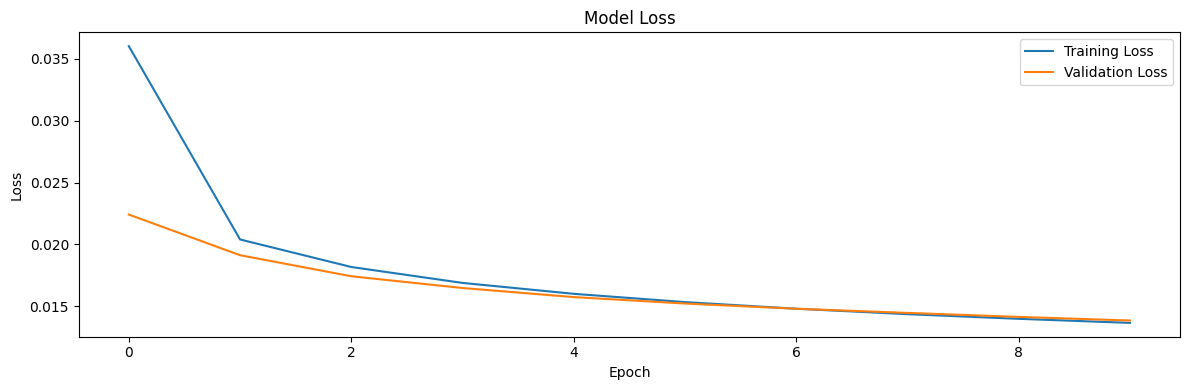

In [8]:
plt.figure(figsize=(12, 4))
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

## Visualize Original vs Reconstructed Images

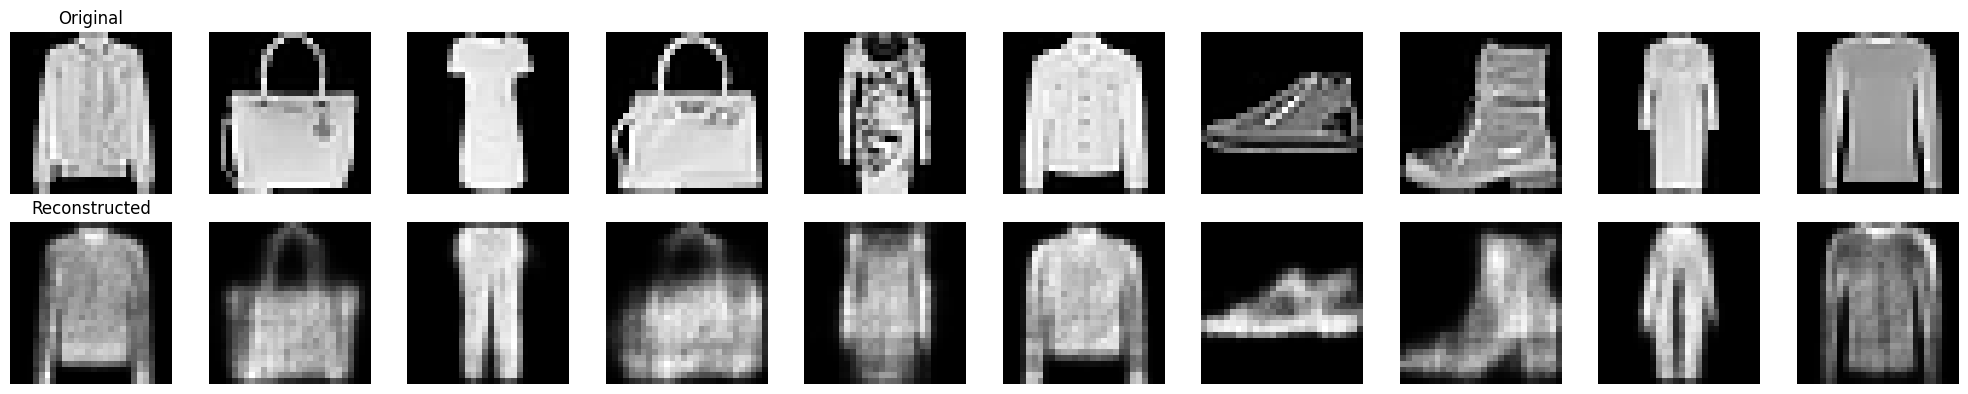

In [9]:
n = 10  # Number of images to display
decoded_imgs = autoencoder.predict(X_test[:n])

plt.figure(figsize=(20, 4))
for i in range(n):
    # Original
    plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.title('Original')

    # Reconstructed
    plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    if i == 0:
        plt.title('Reconstructed')

plt.tight_layout()
plt.show()

## Visualize Latent Space

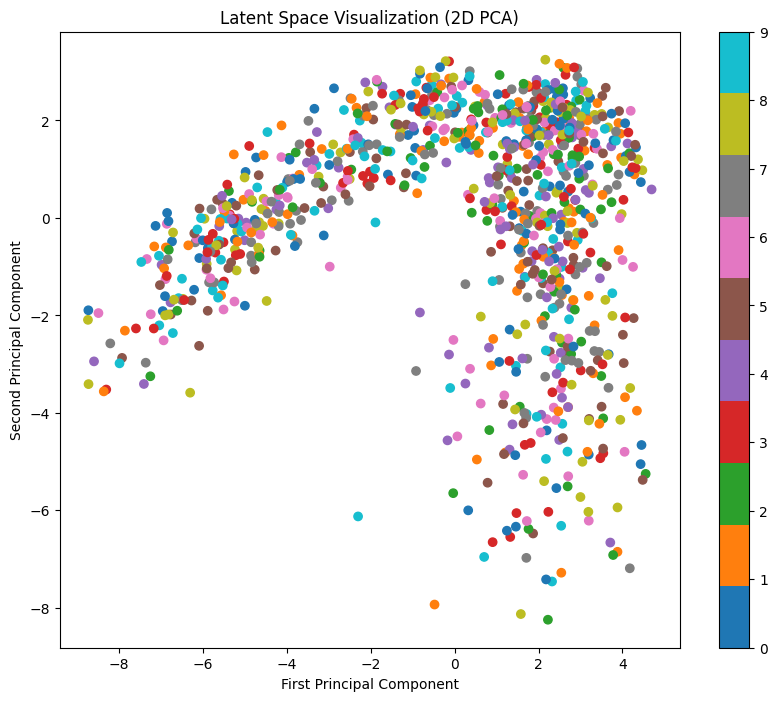

In [10]:
latent_vectors = autoencoder.predict(X_test[:1000], output_latent=True)

pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_vectors)

plt.figure(figsize=(10, 8))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=y[:1000].astype(int), cmap='tab10')
plt.colorbar()
plt.title('Latent Space Visualization (2D PCA)')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

## Evaluate the model

Text(0.5, 1.0, 'Latent Space Distribution')

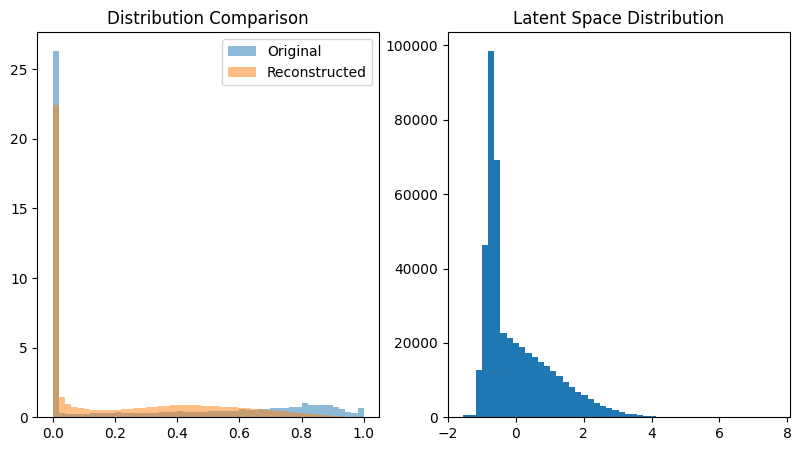

In [11]:
results = {}

# 1. Reconstruction Error Metrics
X_test_reconstructed = autoencoder.predict(X_test)
X_train_reconstructed = autoencoder.predict(X_train)

results['mse_test'] = mean_squared_error(X_test, X_test_reconstructed)
results['mae_test'] = mean_absolute_error(X_test, X_test_reconstructed)
results['mse_train'] = mean_squared_error(X_train, X_train_reconstructed)
results['mae_train'] = mean_absolute_error(X_train, X_train_reconstructed)

# 2. Feature Preservation
correlations = []
for i in range(X_test.shape[1]):
    corr, _ = pearsonr(X_test[:, i], X_test_reconstructed[:, i])
    if not np.isnan(corr):
        correlations.append(corr)
results['avg_feature_correlation'] = np.mean(correlations)

# 3. Latent Space Analysis
latent_train = autoencoder.predict(X_train, output_latent=True)
latent_test = autoencoder.predict(X_test, output_latent=True)

results['latent_skewness'] = np.mean([np.abs(np.mean(latent_test[:, i] ** 3))
                                        for i in range(latent_test.shape[1])])
results['latent_kurtosis'] = np.mean([np.mean(latent_test[:, i] ** 4) - 3
                                        for i in range(latent_test.shape[1])])

# 4. Compression Efficiency
n_input_features = X_test.shape[1]
n_latent_features = latent_test.shape[1]
results['compression_ratio'] = n_input_features / n_latent_features

pca = PCA(n_components=n_latent_features)
pca.fit(latent_test)
results['explained_variance_ratio'] = pca.explained_variance_ratio.sum()

# 5. Distribution Matching
def approximate_kl_divergence(p, q):
    p = np.clip(p, 1e-10, 1)
    q = np.clip(q, 1e-10, 1)
    p = p / p.sum()
    q = q / q.sum()
    return np.sum(p * np.log(p / q))

kl_divs = []
n_features_to_check = min(10, X_test.shape[1])
for i in range(n_features_to_check):
    hist_orig, _ = np.histogram(X_test[:, i], bins=50, density=True)
    hist_recon, _ = np.histogram(X_test_reconstructed[:, i], bins=50, density=True)
    kl_divs.append(approximate_kl_divergence(hist_orig, hist_recon))
results['avg_kl_divergence'] = np.mean(kl_divs)

# 6. Visualizations
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.hist(X_test.ravel(), bins=50, alpha=0.5, label='Original', density=True)
plt.hist(X_test_reconstructed.ravel(), bins=50, alpha=0.5, label='Reconstructed', density=True)
plt.title('Distribution Comparison')
plt.legend()

plt.subplot(132)
plt.hist(latent_test.ravel(), bins=50)
plt.title('Latent Space Distribution')

In [12]:
print("Evaluation Results:")
for k, v in results.items():
    print(f"{k}: {v}")

Evaluation Results:
mse_test: 0.03563702004658265
mae_test: 0.11041707420693547
mse_train: 0.035587902817990354
mae_train: 0.11024269797983545
avg_feature_correlation: 0.7689345609509709
latent_skewness: 1.3513897110286115
latent_kurtosis: 1.4631146187055855
compression_ratio: 24.5
explained_variance_ratio: 0.9999999999999905
avg_kl_divergence: 1.8823393517172284
